# Simple example of Bayesian Neural Network

In normal/traditional ANN with a training dataset $D = (x_{i}, y_{i}), i = 1...N$ the goal of the training is to maximize the likelihood between $y_{i}$ and $F_{\theta}(x_{i})$ where $F_{\theta}()$ represents the NN function with a set of parameters $\theta$

$$
\theta^* = argmax \sum_{(x_{i}, y_{i})} log[p(y_i | x_{i}, \theta)]
$$

In classification cases a loss function of for example cross-entropy is used and the goal of the training loop is to minimize it using gradient descent variations. With cross-etnropy the equation above is equivanelt to the one below:

$$
\theta^* = argmin \sum_{(x_{i}, y_{i})} L(F_{\theta}(x_i), y_i)
$$

In contrast, in a Bayesian Neural Network (BNN), the paramets $\theta$ are not fixed. During the optimization process, the goal is to learn the parameters of an assumed probability distribution. 

$$
\mu^*, \Sigma^* = argmax \sum_{(x_{i}, y_{i})} log[p(y_i | x_{i}, \theta)] - KL[p(\theta), p(\theta_0)]
$$

Assuming normal distribution for the parameters: $\theta \sim {\sf Norm}(\mu, \Sigma)$ and KL divergence term between $p(\theta)$ and $p(\theta_{0})$, where $\theta_{0} \sim {\sf Norm}(0, 1)$, forces the mean and variances not to overfit to each point and acts as regularization. Writing it based on cross-entropy loss function:

$$
\mu^*, \Sigma^* = argmin \sum_{(x_{i}, y_{i})} L(F_{\theta}(x_i), y_i) + KL[p(\theta), p(\theta_0)]
$$


During the inference, the parameters are sampled from their (fitted) distribution for a desired number of times, and the likelihood is calculate in a forward pass for each sample of parameters. At the end, the outputs can be averaged. Since we are using multiple outputs this resembles an ensemble technique. Also the average model prediction can give relative probability that can be a measure of uncertainty.

Two main advantages of BNN that make them a very powerful tool are:
- They can be used when the amount of available training data is small and we want to avoid overfitting. 
- They make it possible to estimate the uncertainties in predictions.

Reference paper with a lot more details and approaches: [Hands-on Bayesian Neural Network](https://arxiv.org/pdf/2007.06823.pdf)

A simple dataset from sklearn datasets [Link](https://scikit-learn.org/stable/datasets/toy_dataset.html) is used to show the principle. [Wine Recognition Dataset](https://archive.ics.uci.edu/ml/datasets/wine)


## Importing the libraries

In [1]:
import numpy as np
from sklearn import datasets
import torch
import torch.nn as nn
import torch.optim as optim
import torchbnn as bnn
import matplotlib.pyplot as plt
%matplotlib inline 

## Loading the data and visualization

In [2]:
dataset = datasets.load_wine()

In [3]:
data   = dataset.data
target = dataset.target 

In [4]:
idx = 10
print("Features:")
print(data[idx])
print("Label:")
print(target[0])

Features:
[1.41e+01 2.16e+00 2.30e+00 1.80e+01 1.05e+02 2.95e+00 3.32e+00 2.20e-01
 2.38e+00 5.75e+00 1.25e+00 3.17e+00 1.51e+03]
Label:
0


We define a function to visulize the data. The arguments are the feasures/embedding for the sample points, their corresponding label (predicted or ture), title, and desired dimensions. Since we want to do a simple visualization we can pick two out of the 13 features for visualization.

In [5]:
def draw(data, label, title, dim1 = 0, dim2 = 1):
    fig = plt.figure(figsize = (14, 6))

    plt.scatter(data[:, dim1], data[:, dim2], c = label, marker='v')
    
    plt.colorbar()
    
    plt.title(title)
    
    plt.show()

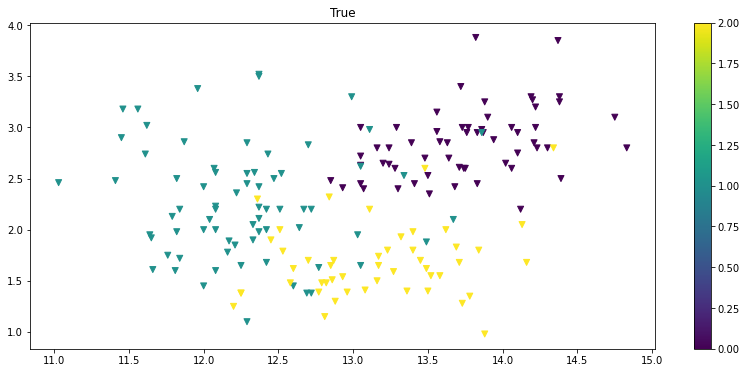

In [6]:
draw(data, target, "True", 0, 5)

## Defining the model

The only pre-processing step is to transform the numpy arrays read from the sklearn into torch tensors.

In [7]:
data_tensor   = torch.tensor(data, dtype = torch.float32)
target_tensor = torch.tensor(target, dtype = torch.long)

The simple model has one hidden layer with a (customizable) high number of features and an output layer equal to number of classes.

In [8]:
def BNN(input_features = 13, hidden_features = 1000, n_classes = 3):

    model = nn.Sequential(
        bnn.BayesLinear(prior_mu=0, prior_sigma=.3, in_features=input_features, out_features=hidden_features),
        nn.ReLU(),
        bnn.BayesLinear(prior_mu=0, prior_sigma=.3, in_features=hidden_features, out_features=n_classes),
    )
    
    return model

Setting up the model and defining loss functions and the optimizer.

In [9]:
n_classes = len(np.unique(target))

model = BNN(n_classes = n_classes)
Loss = nn.CrossEntropyLoss()
KL = bnn.BKLLoss(reduction='mean', last_layer_only=False)
alfa = 0.05
optimizer = optim.Adam(model.parameters(), lr=0.01)

## Training the model

Usual pytorch way of training the model:
With this number of features and training numbers, a normal ANN would overfit to all datapoints.

In [10]:
loss_array = []
for step in range(6000):
    output  = model(data_tensor)
    loss    = Loss(output, target_tensor)
    kl_loss = KL(model)
    total_loss = loss + alfa * kl_loss
    if step % 100 == 0:
        loss_array.append(total_loss.detach().cpu().numpy().squeeze())
    
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()

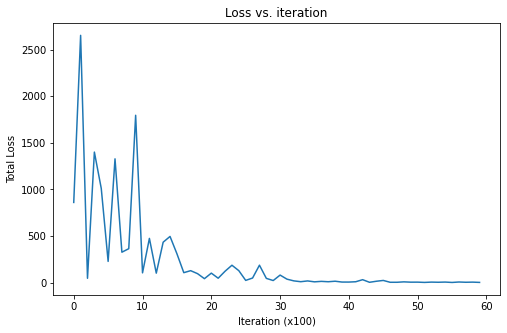

In [11]:
fig = plt.figure(figsize = (8, 5))
plt.plot(loss_array)
plt.title("Loss vs. iteration")
plt.xlabel("Iteration (x100)")
plt.ylabel("Total Loss")
plt.show()

## Evaluating the model

From the output of the last iteration, the predicted class for each sample is calculated by doing an argmax of the labels

Accuracy = 84.26966094970703 %


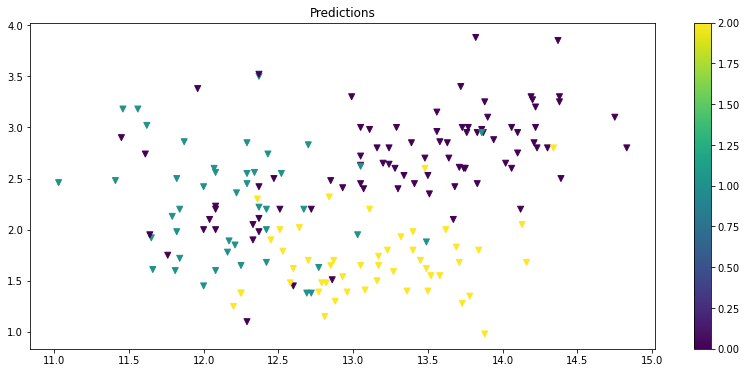

In [12]:
_, preds = torch.max(output.data, 1)
size     = len(target_tensor)
TP_TN      = (preds == target_tensor).sum()
print('Accuracy = {} %'.format(100 * TP_TN / size))

draw(data, preds, "Predictions", 0, 5)

## Inference

During the inference procedure, the parameters are sampled from the fitted model distributions for N number of times. At each step the most likely class is estimated. [the reference paper suggests to average the probability of each class, but the way this model is constructed it is not outputing the probabilities directly.]

The probability of each class for each sample can be calculated by the number of times it is assigned to a certain class by the total number of iterations.

In [13]:
N = 100

class_1_probs = np.zeros(len(data_tensor))
class_2_probs = np.zeros(len(data_tensor))
class_3_probs = np.zeros(len(data_tensor))


for i in range(N):
    output = model(data_tensor)
    _, preds = torch.max(output.data, 1)
    preds = preds.detach().cpu().numpy().squeeze()
    
    class_1_indices = np.where(preds == 0)
    class_1_probs[class_1_indices] += 1
    
    class_2_indices = np.where(preds == 1)
    class_2_probs[class_2_indices] += 1
    
    class_3_indices = np.where(preds == 2)
    class_3_probs[class_3_indices] += 1

class_1_probs /= N
class_2_probs /= N
class_3_probs /= N

In [14]:
probabilities = np.stack((class_1_probs.T, class_2_probs.T, class_3_probs.T)).reshape(3, -1).T
print(probabilities)

[[0.98 0.02 0.  ]
 [0.99 0.01 0.  ]
 [0.99 0.01 0.  ]
 [0.99 0.01 0.  ]
 [0.07 0.93 0.  ]
 [0.99 0.01 0.  ]
 [0.99 0.01 0.  ]
 [0.99 0.01 0.  ]
 [0.99 0.01 0.  ]
 [0.99 0.01 0.  ]
 [1.   0.   0.  ]
 [0.99 0.01 0.  ]
 [1.   0.   0.  ]
 [0.99 0.01 0.  ]
 [1.   0.   0.  ]
 [0.99 0.01 0.  ]
 [0.99 0.01 0.  ]
 [0.98 0.02 0.  ]
 [1.   0.   0.  ]
 [0.72 0.28 0.  ]
 [0.27 0.73 0.  ]
 [0.43 0.57 0.  ]
 [0.99 0.01 0.  ]
 [0.99 0.01 0.  ]
 [0.75 0.25 0.  ]
 [0.11 0.89 0.  ]
 [0.99 0.01 0.  ]
 [0.99 0.01 0.  ]
 [0.87 0.13 0.  ]
 [0.99 0.01 0.  ]
 [0.99 0.01 0.  ]
 [0.99 0.01 0.  ]
 [0.98 0.02 0.  ]
 [0.98 0.02 0.  ]
 [0.98 0.02 0.  ]
 [0.91 0.09 0.  ]
 [0.89 0.11 0.  ]
 [0.99 0.01 0.  ]
 [0.99 0.01 0.  ]
 [0.36 0.64 0.  ]
 [0.51 0.49 0.  ]
 [0.99 0.01 0.  ]
 [0.99 0.01 0.  ]
 [0.17 0.82 0.01]
 [0.92 0.08 0.  ]
 [0.97 0.03 0.  ]
 [0.99 0.01 0.  ]
 [0.98 0.02 0.  ]
 [0.98 0.02 0.  ]
 [0.99 0.01 0.  ]
 [0.99 0.01 0.  ]
 [0.99 0.01 0.  ]
 [0.99 0.01 0.  ]
 [0.99 0.01 0.  ]
 [0.98 0.02 0.  ]
 [0.98 0.0

Unfortunately, the dataset is too small for plotting reliability diagrams and data is very noisy. We can try this principle in another larger dataset.